In [51]:
#%matplotlib widget
import scipy
import matplotlib.pyplot as plt
import numpy as np
import random
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os

In [52]:
fixed_SNR_opt = True
save_data = True
load_data = False
load_number = 5
iterations = 20

if fixed_SNR_opt:
    desired_SNR = 75
else:
    desired_SNR = 0.67

noise_seed = 5
np.random.seed(noise_seed)

slice_num = 3
pat_id = "BLSA_1935_06_MCIAD_m79"
pat_tag = pat_id[-3:]

cwd_temp = os.getcwd()
base_file = 'Regularization'
cwd_full = cwd_temp.split(base_file, 1)[0]

path = f'{cwd_full}{base_file}/MB_References/{pat_id}/SNR_info.pkl'

isFile = os.path.isfile(path) 

if load_data:
    date_tag = '18Apr24'

else:
    date = date.today()
    day = date.strftime('%d')
    month = date.strftime('%B')[0:3]
    year = date.strftime('%y')
    date_tag = f'{day}{month}{year}'

output_path = f'{cwd_full}{base_file}/Noise_Generation/Noise_Sets/{pat_tag}_slice{slice_num}_SNR{desired_SNR}_{date_tag}'
os.makedirs(output_path, exist_ok = True)

In [53]:
brain_data = scipy.io.loadmat(f'{cwd_full}{base_file}/MB_References/{pat_id}/NESMA_cropped_slice{slice_num}.mat')
I_raw = brain_data['slice_oi']

n_vert, n_hori, n_elements = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements)*(t_increment_brain), n_elements)

In [54]:
if isFile:
    print('Data was loaded in')
    with open(path, 'rb') as handle:
        dict = pickle.load(handle)
        pat_id_check = dict["Patient_ID"]
        sigma_slice = dict['slice_num']
        main_sigma = dict['sigma']
        vert1 = dict['vert1']
        vert2 = dict['vert2']
        hori1 = dict['hori1']
        hori2 = dict['hori2']
        sigma_SNR = dict['SNR']
        mask_amplitude = dict['mask_amplitude']
        date_stamp = dict['date_stamp']
        n_vert = dict['n_vert']
        n_hori = dict['n_hori']
        n_elem = dict['n_elem']
        mask_shape = dict['mask_shape']
        handle.close()

    print(f'SNR data for {pat_tag} was loaded in successfully')
    print(f'SNR of brain sigma slice = {sigma_SNR:.2f}')
    print(f'Region of interest = [{vert1}, {vert2}; {hori1}, {hori2}]')
else:
    raise ValueError('There is not a valid SNR file to load')

if not fixed_SNR_opt:
    goal_SNR = sigma_SNR*desired_SNR
else:
    goal_SNR = desired_SNR

if goal_SNR > sigma_SNR:
    raise ValueError(f'The desired SNR of {desired_SNR} is greater than the ground truth {sigma_SNR}')

Data was loaded in
SNR data for m79 was loaded in successfully
SNR of brain sigma slice = 102.19
Region of interest = [92, 105; 75, 120]


In [55]:
def det_noise_factor(sigma_start, sigma_SNR, des_SNR):
    #This function uses the data stored for a brain scan to determine the right amount of noise to add
    S_0 = sigma_SNR*sigma_start
    sigma_final = S_0/des_SNR
    sigma_added = (sigma_final**2 - sigma_start**2)**(1/2)
    return sigma_added

def mask_data(data, mask_amp):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(data)
    mask = I_masked[:,:,0]<mask_amp
    I_masked[mask] = 0
    return I_masked, mask

def add_noise(data, mask_amp, sig):
    masked_data, mask = mask_data(data, mask_amp)
    noise = np.random.normal(0, sig, data.shape)
    noise[mask] = 0
    masked_noise = noise
    noised_data = masked_data + masked_noise
    return noised_data


In [56]:
noise_factor = det_noise_factor(main_sigma, sigma_SNR, goal_SNR)
S_0 = sigma_SNR*main_sigma
sigma_final = S_0/goal_SNR
print(sigma_final)

I_masked, mask = mask_data(I_raw, mask_amplitude)
print(f'Shape of mask is {mask.shape}')

13.083681931367966
Shape of mask is (145, 185)


In [57]:
if save_data:
    hprParams = {
        "SNR_goal": goal_SNR,
        "SNR_desired": desired_SNR,
        "num_noise_realizations": iterations,
        "patient_id": pat_id,
        "slice_num": slice_num,
        "noise_date_stamp": date_stamp,
        "rand_seed": noise_seed
    }

    f = open(f'{output_path}/hprParameter.pkl','wb')
    pickle.dump(hprParams,f)
    f.close()

In [58]:
if load_data:
    filename = f'{output_path}/{pat_tag}_slice{slice_num}_iter{load_number}.pkl'
    fileObject = open(filename, 'rb')
    I_noised = pickle.load(fileObject)
    fileObject.close()
    print("Data was loaded in")
else:
    for i in range(iterations):
        I_noised = add_noise(I_raw, mask_amplitude, noise_factor)

        if save_data:
            filename = f'{output_path}/{pat_tag}_slice{slice_num}_iter{i+1}.pkl'
            fileObject = open(filename, 'wb')
            pickle.dump(I_noised, fileObject)
            fileObject.close()

In [59]:
if sigma_slice == slice_num:
    noise_set = I_noised[vert1:vert2,hori1:hori2,-1]
    noise_sigma = np.std(noise_set[noise_set != 0])
    init_set = I_noised[vert1:vert2,hori1:hori2,0]
    S_0 = np.mean(init_set[init_set != 0])
    new_SNR = S_0/noise_sigma

    print(f"The goal SNR was {goal_SNR}")
    print(f"The SNR of the most recent noised iteration is {new_SNR}")
else:
    print(f"This scan is hard to determine the new SNR because the sigma value is not calculable")
    print(f'Check noise generation for slice {slice_num} of {pat_tag} to check code is working')

This scan is hard to determine the new SNR because the sigma value is not calculable
Check noise generation for slice 3 of m79 to check code is working


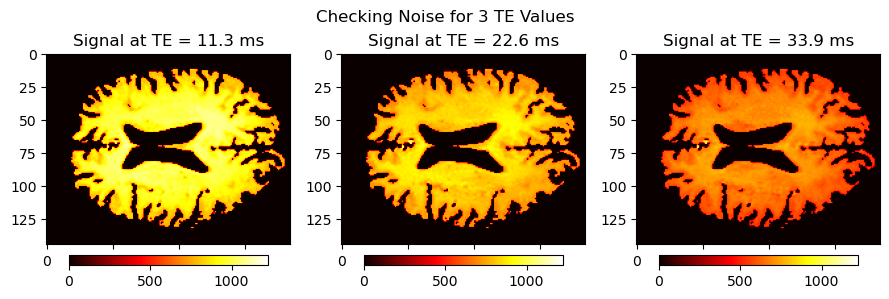

In [60]:
fig, ax = plt.subplots(1,3,figsize=(9,3),tight_layout=True)
fig.suptitle('Checking Noise for 3 TE Values')

for i in range(3):

    NR = ax[i].imshow(I_noised[:,:,i], cmap = 'hot', vmin = 0, vmax = np.max(I_noised))
    fig.colorbar(NR,ax=ax[i], fraction=0.046, pad=0.05, location = 'bottom')
    ax[i].set_title(f'Signal at TE = {tdata[i]:.1f} ms')

plt.show()

The mask is consistent for each TE


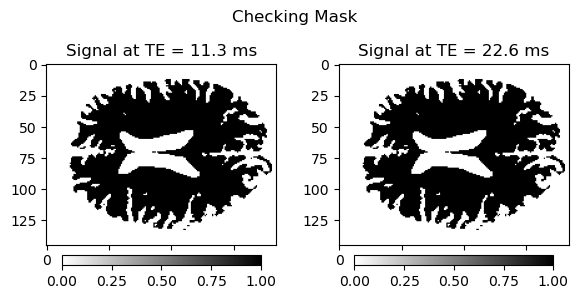

In [61]:
fig, ax = plt.subplots(1,2,figsize=(6,3),tight_layout=True)
fig.suptitle('Checking Mask')

for i in range(2):

    NR = ax[i].imshow(I_noised[:,:,i]>0, cmap = 'binary')
    fig.colorbar(NR,ax=ax[i], fraction=0.046, pad=0.05, location = 'bottom')
    ax[i].set_title(f'Signal at TE = {tdata[i]:.1f} ms')

assert(np.all((I_noised[:,:,0]>0) == (I_noised[:,:,1]>0)))
print("The mask is consistent for each TE")
plt.show()




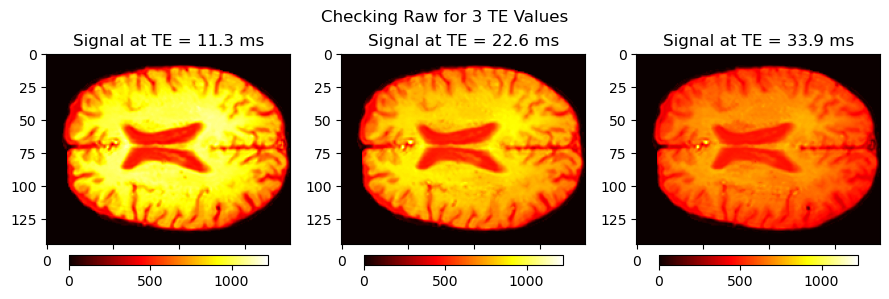

In [62]:
fig, ax = plt.subplots(1,3,figsize=(9,3),tight_layout=True)
fig.suptitle('Checking Raw for 3 TE Values')

for i in range(3):

    NR = ax[i].imshow(I_raw[:,:,i], cmap = 'hot', vmin = 0, vmax = np.max(I_noised))
    fig.colorbar(NR,ax=ax[i], fraction=0.046, pad=0.05, location = 'bottom')
    ax[i].set_title(f'Signal at TE = {tdata[i]:.1f} ms')

plt.show()